# COURSE: A deep understanding of deep learning
## SECTION: ANNs
### LECTURE: Multi-output ANN (iris dataset)
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/dudl/?couponCode=202208

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')


/tmp/ipykernel_9626/638888636.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
PATH = "iris_multioutput.pt"
DEVICE = "cpu"
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# Import and process the data

In [3]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

# check out the first few lines of data
iris.head()


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


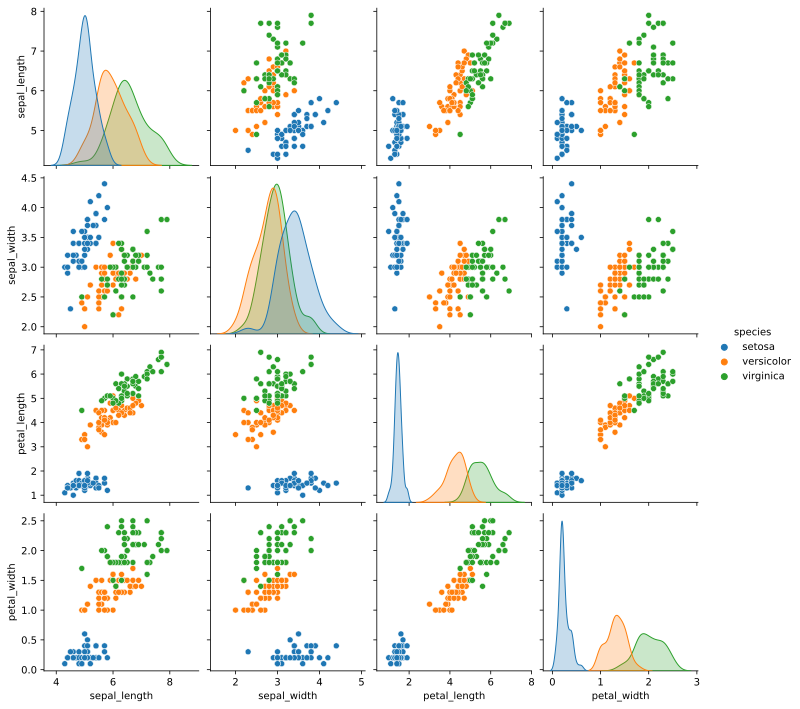

In [4]:
# some plots to show the data
sns.pairplot(iris, hue='species')
plt.show()


In [5]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species == 'versicolor'] = 1
labels[iris.species == 'virginica'] = 2


data.shape


torch.Size([150, 4])

In [6]:
class IrisClassifierModel(nn.Module):
    def __init__(self, _in, _out, depth=1, _params=None):
        super().__init__()
        self.layers = nn.ModuleList(
            [nn.Linear(_in, _out)] if depth == 1 else [nn.Linear(_in, _params)] +
            [nn.Linear(_params, _params)]*(depth-2) +
            [nn.Linear(_params, _out)]
        )

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        return self.layers[-1](x)


In [7]:
class IrisClassifier():
    def __init__(self, lr, numepochs, depth=1, _params=None):
        # model architecture
        self.lr = lr
        self.numepochs = numepochs
        self.model = IrisClassifierModel(4, 3, depth, _params)
        # loss function
        self.lossfun = nn.CrossEntropyLoss()
        # optimizer
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=.01)
        self.accs = []

    def train(self, data, labels):
        # initialize losses
        self.losses = torch.zeros(self.numepochs)
        self.model.train()
        for epochi in range(self.numepochs):

            # forward pass
            yHat = self.model.forward(data)

            # compute loss
            loss = self.lossfun(yHat, labels)
            self.losses[epochi] = loss

            # backprop
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # compute accuracy
            # booleans (false/true)
            matches = torch.argmax(yHat, axis=1) == labels
            matchesNumeric = matches.float()              # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric)  # average and x100
            # add to list of accuracies
            self.accs.append(accuracyPct)

    def getAcc(self, a, b):
        return 100*torch.mean((a == b).float())

    def eval(self, data, labels):
        self.model.eval()
        with torch.inference_mode():
            # final forward pass
            self.predictions = self.model.forward(data)

        predlabels = torch.argmax(self.predictions, axis=1)

        self.totalacc = self.getAcc(predlabels, labels)
        self.setosaacc = self.getAcc(
            predlabels[iris.species == 'setosa'], labels[iris.species == 'setosa'])
        self.versicoloracc = self.getAcc(
            predlabels[iris.species == 'versicolor'], labels[iris.species == 'versicolor'])
        self.virginicaacc = self.getAcc(
            predlabels[iris.species == 'virginica'], labels[iris.species == 'virginica'])

#         print(f'''
# total: {self.totalacc}
# setosa: {self.setosaacc}
# versicolor: {self.versicoloracc}
# virginica: {self.virginicaacc}
# ''')
    def print(self):
        for name, param in self.model.named_parameters():
            print(name, param.shape)

    def load(self, path):
        self.model.load_state_dict(torch.load(path))

    def save(self, path):
        torch.save(self.model.state_dict(), path)


# Depth v Breadth

# Train the model

In [8]:
classifier = IrisClassifier(.01, 1100,3,16)
classifier.train(data, labels)
classifier.eval(data, labels)
classifier.totalacc


tensor(98.)

In [9]:
lr = 0.01
epoch = 1100
x = torch.arange(2,8)#depth
y = torch.arange(1,17)#breadth
title = f"lr={lr}, epoch={epoch}"
xlabel = "depth"
ylabel = "breadth"
# x = torch.linspace(1e-10, 1,10)#lr
# y = torch.round(torch.linspace(100, 1100,10))#epochs
# title = "depth=1"
# xlabel = "lr"
# ylabel = "epoch"

In [10]:
M = len(y)
N = len(x)
accs = torch.zeros(M,N)
for j in range(M):
    for i in range(N):
        classifier = IrisClassifier(lr,epoch,x[i], y[j])
        # classifier = IrisClassifier(x[i], y[j])
        classifier.train(data, labels)
        classifier.eval(data, labels)
        accs[j][i] = classifier.totalacc

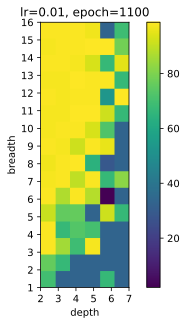

In [12]:
plt.imshow(accs, extent=[x[0],x[-1],y[0],y[-1]], origin="lower")
plt.title(title)
plt.xticks(x)
plt.yticks(y)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.colorbar()
plt.show()

In [18]:
amax = int(accs.argmax())
xval = amax % accs.shape[1]
yval = amax // accs.shape[1]
print(f"max: {xlabel}: {x[xval]}, {ylabel}: {y[yval]}, {accs[yval][xval]}")

max: depth: 4, breadth: 8, 98.66667175292969


In [24]:
classifier = IrisClassifier(.01,1100,4,8)
classifier.print()
classifier.train(data, labels)
classifier.eval(data, labels)
classifier.totalacc

layers.0.weight torch.Size([8, 4])
layers.0.bias torch.Size([8])
layers.1.weight torch.Size([8, 8])
layers.1.bias torch.Size([8])
layers.3.weight torch.Size([3, 8])
layers.3.bias torch.Size([3])


tensor(98.)

# Evaluate the model

In [ ]:
# classifier.eval(data, labels)


In [ ]:
# classifier.save(PATH)


# Visualize the results

In [ ]:
# report accuracy
print('Final accuracy: %g%%' % classifier.totalacc)

fig, ax = plt.subplots(1, 2, figsize=(13, 4))

ax[0].plot(classifier.losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(classifier.accs)
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_title('Accuracy')
plt.show()
# run training again to see whether this performance is consistent


In [ ]:
# confirm that all model predictions sum to 1, but only when converted to softmax
sm = nn.Softmax(1)
torch.sum(sm(classifier.predictions), axis=1)


In [ ]:
# plot the raw model outputs

fig = plt.figure(figsize=(10, 4))

plt.plot((classifier.predictions).detach(), 's-', markerfacecolor='w')
plt.xlabel('Stimulus number')
plt.ylabel('Probability')
plt.legend(['setosa', 'versicolor', 'virginica'])
plt.show()

# try it again without the softmax!


# Additional explorations

In [ ]:
# 1) When the loss does not reach an asymptote, it's a good idea to train the model for more epochs. Increase the number of
#    epochs until the plot of the losses seems to hit a "floor" (that's a statistical term for being as small as possible).
#
# 2) We used a model with 64 hidden units. Modify the code to have 16 hidden units. How does this model perform? If there
#    is a decrease in accuracy, is that decrease distributed across all three iris types, or does the model learn some
#    iris types and not others?
#
# 3) Write code to compute three accuracy scores, one for each iris type. In real DL projects, category-specific accuracies
#    are often more informative than the aggregated accuracy.
#
